# Encontrando Grupos de Causas de Morte (Brasil)
---

### Importando bibliotecas de Processamento e Visualização de Dados

In [1]:
import pandas as pd               # Data Handling
import numpy as np                # Scientific computing
import matplotlib.pyplot as plt   # Data visualization

import os                         #File and path handling
import dataframe_image as dfi     #Save dataframe as image
import imageio

from IPython.display import clear_output

#### Configurações

In [4]:
import warnings; warnings.filterwarnings('ignore')
import seaborn as sns; sns.set()

### Importando Bibliotecas de Machine Learning

In [2]:
from sklearn.preprocessing import MinMaxScaler as mms

In [3]:
from clusteval import clusteval
from sklearn.cluster import (AffinityPropagation, AgglomerativeClustering, Birch,
                             DBSCAN, OPTICS, KMeans, MeanShift, MiniBatchKMeans
                            )
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

#### Funções

In [5]:
def set_fig(x=5, y=3, grid=111):
    
    fig = plt.figure(figsize=(x,y)); ax = fig.add_subplot(grid)
    return fig, ax

### Lendo Dados (csv com pandas)

In [6]:
cod = pd.read_csv('data/cod_brasil_obitos.csv')

In [7]:
cod.head()

_id                   Causa          Causa Classificada  UF ID  \
0  1650550  Glomerulonefrite aguda  108 Glomerulonefrite aguda    135   
1  1650655          Câncer de mama          020 Câncer de mama    135   
2  1650741  Glomerulonefrite aguda  119 Glomerulonefrite aguda    135   
3  1650752                Hepatite                086 Hepatite    135   
4  1650782              Apendicite              086 Apendicite    135   

  Unidade de federação   Sexo                          Idade   Ano  \
0               Brasil  Ambos  Todas as idades (padronizado)  1990   
1               Brasil  Ambos  Todas as idades (padronizado)  2000   
2               Brasil  Ambos  Todas as idades (padronizado)  2014   
3               Brasil  Ambos  Todas as idades (padronizado)  2010   
4               Brasil  Ambos  Todas as idades (padronizado)  2016   

   Taxa de mortalidade  Número de óbitos  Mortalidade Proporcional  \
0                 0.18                 0                         0   
1                 9.19                 0                         0   
2                 0.03                 0                         0   
3                 0.62                 0                         0   
4                 0.66                 0                         0   

   Classificação  top  filtro_1  
0            108  NaN       NaN  
1             20  NaN       NaN  
2            119  NaN       NaN  
3             86  NaN       NaN  
4             86  NaN       NaN

---

# Pre-Processamento de Dados

### Montando Tabela base de Input para Algoritimos de Cluster

In [8]:
ser = [pd.Series(sorted(cod['Ano'].unique()))]

taxas_causas = []
for causa in cod['Causa'].unique():
    taxas_causas.append(
        cod[cod['Causa']==causa][['Taxa de mortalidade', 'Ano']]
        .sort_values(by='Ano')
        .rename(columns={'Taxa de mortalidade': causa})
        .iloc[:,0]
        .reset_index(drop=True)
    ) 
    
causes_df = pd.concat(ser + taxas_causas, axis=1, join='inner').rename(columns={0:'Ano'})

### Selecionando Input dos Algorítimos

In [11]:
X = causes_df.set_index('Ano').T

#### Engenharia de Dados (Diferença da Série Histórica)

In [19]:
X_dif = pd.DataFrame(np.diff(X),
                     columns = [str(i)+'-'+str(j) for i,j in zip(X.columns, X.columns[1:])],
                     index = X.index
)

In [17]:
X.head()

Ano                           1990   1991   1992   1993   1994   1995   1996  \
Glomerulonefrite aguda        0.18   0.16   0.14   0.12   0.11   0.09   0.08   
Câncer de mama                8.25   8.22   8.42   8.74   8.90   8.98   9.04   
Hepatite                      0.85   0.82   0.81   0.81   0.80   0.79   0.76   
Apendicite                    0.75   0.73   0.72   0.72   0.70   0.68   0.68   
Cardiomiopatia e miocardite  10.90  11.23  11.66  12.20  12.58  12.76  13.04   

Ano                           1997   1998   1999  ...  2008  2009  2010  2011  \
Glomerulonefrite aguda        0.08   0.07   0.07  ...  0.04  0.03  0.03  0.03   
Câncer de mama                9.05   9.17   9.24  ...  8.72  8.66  8.61  8.52   
Hepatite                      0.75   0.75   0.78  ...  0.69  0.66  0.62  0.59   
Apendicite                    0.66   0.66   0.66  ...  0.67  0.68  0.68  0.68   
Cardiomiopatia e miocardite  13.06  13.11  13.07  ...  9.49  9.23  9.00  8.77   

Ano                          2012  2013  2014  2015  2016  2017  
Glomerulonefrite aguda       0.03  0.03  0.03  0.03  0.03  0.03  
Câncer de mama               8.36  8.23  8.07  8.05  8.14  8.12  
Hepatite                     0.54  0.51  0.48  0.46  0.45  0.47  
Apendicite                   0.68  0.67  0.66  0.66  0.66  0.65  
Cardiomiopatia e miocardite  8.54  8.41  8.29  8.22  8.31  8.59  

[5 rows x 28 columns]

---

# Comparando Algorítimos de Cluster

# Refazer ***

### Modelando tabela usando algorítimos da biblioteca de machine learning 'SciKitLearn'

In [477]:
algs = [AffinityPropagation, AgglomerativeClustering, DBSCAN, OPTICS, MeanShift]
metrics = [silhouette_score, calinski_harabasz_score, davies_bouldin_score]

keys = [str(alg).split('.')[-1][:-2] for alg in algs]
metrics_names = [str(metric).split(' ')[1] for metric in metrics]

values = [{'damping': 0.9},
          {'n_clusters': None, 'distance_threshold': 8},
          {'min_samples': 1, 'eps': 10},
          {}, {}]

params = {key: param for key, param in zip(keys, values)}
algs = {key: alg for key, alg in zip(keys, algs)}

models = {} 
for key in keys:
    models[key] = algs[key](**params[key]).fit(X) 

n_clus, scrs = {}, []
for key in keys: 
    n_clus[key] = len(np.unique(models[key].labels_))
print('Nº de Clusters:', n_clus)

Nº de Clusters: {'AffinityPropagation': 21, 'AgglomerativeClustering': 29, 'DBSCAN': 15, 'OPTICS': 5, 'MeanShift': 9}


### Visualizando resultados para diferentes algorítimos de cluster

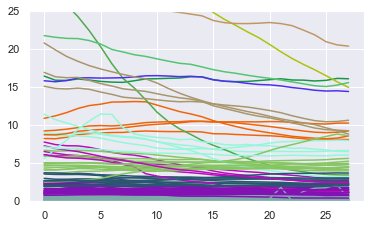

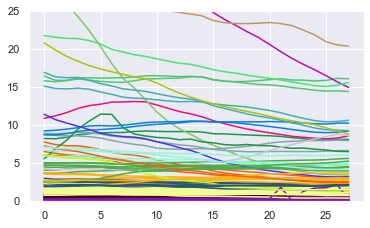

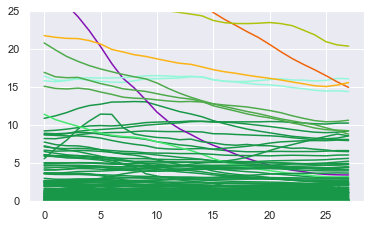

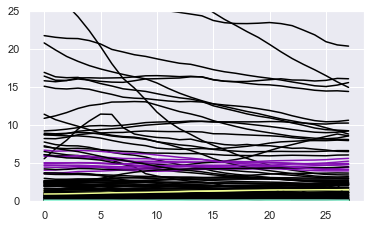

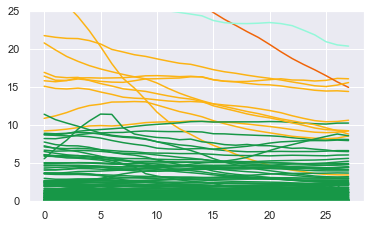

In [42]:
colors = [tuple(np.random.choice(range(256), size=3)/255) for i in range(max(n_clus.values()))] + [(0,0,0)]

for key in keys:

#    for ylim in [50,10]:

        fig, ax = set_fig(6,3.5)
        for causa, cluster in zip(causes_df.set_index('Ano'), models[key].labels_):
            causes_df[causa].plot(color=colors[cluster])

        ax.set(ylim=(0, 25))
        plt.show()
        plt.pause(.1)

---

# Optimização de parâmentros para 'Cluster Aglomerativo'

### Calculando Performance Variando o Nº de Clusters

In [21]:
max_clusters = 124
n_clusters = range(2, max_clusters)

metrics = [silhouette_score, davies_bouldin_score]
metrics_names = [str(metric).split(' ')[1] for metric in metrics]

In [39]:
X_i, Y_i = [], []
for x in [X, X_dif]:
    agg_scrs  = []
    Y_n = []
    for n in n_clusters:    
        if n%5==0: clear_output(wait=True); print(f'{n}/{max_clusters}')

        model = AgglomerativeClustering(n_clusters=n, distance_threshold=None).fit(x)
        labels = model.labels_; Y_n.append(labels)

        # Substituindo rótulos "-1" por "0"
        num_labels = len(np.unique(labels))
        #if num_labels==len(X): 
         #   labels[labels==0] = 1

        agg_scrs.append([metric(x, labels) for metric in metrics])

    agg_scrs = pd.DataFrame(mms().fit_transform(agg_scrs), columns=metrics_names, index=n_clusters)
    agg_scrs.index.name='n_clusters'
    X_i.append( agg_scrs )
    
    Y_n = pd.DataFrame(Y_n, columns=X.index, index=n_clusters)
    Y_n .index.name='n_clusters'
    Y_i.append(Y_n)

X_scrs, X_dif_scrs = X_i
Y, Y_dif = Y_i

120/124


### Calculando Número de Clusteres unitários (outliers) e não unitários (reais)

In [40]:
for x, y in zip([X_scrs, X_dif_scrs], [Y, Y_dif]):

    outliers, n_cls_true = [], []
    for n in y.index:

        sums = np.array([sum(y.loc[n]==label) for label in y.loc[n].unique()])

        outliers.append(sum(sums==1))
        n_cls_true.append(len(sums) - sum(sums==1))
    
    n_cls_true = mms().fit_transform(pd.DataFrame(n_cls_true))
    #outliers = mms().fit_transform(pd.DataFrame(outliers))
    x['outliers'], x['n_clusters_true'] = outliers, n_cls_true

### Rotulando clusters unitários (outliers) para exclusão

In [41]:
masks = {}
for y, key in zip([Y, Y_dif], ['serie', 'diff']):
    table = []
    for n in y.index:
        row = y.loc[n]
        new_row = []
        for label in row: new_row.append((row==label).sum()!=1)
        table.append(new_row)
    masks[key] = pd.DataFrame(table, index=y.index, columns=y.columns)

### Animação Otimização Número de Clusters (Escondendo Clusters Unitários)

In [ ]:
choice = int(input('Clusters por Série ou Diferença da Série? [0 ou 1]'))
    
for n in Y.index:

    mask = masks[['serie', 'diff'][choice]].loc[n]
    y = [Y, Y_dif][choice].loc[n][mask]
    
    avgs = [X[mask][y==cluster].mean().mean() for cluster in y.unique()]
    sorted_clusters = pd.Series(avgs, index=y.unique()).sort_values(ascending=False).index
    cmap = {cluster:i for cluster, i in zip(sorted_clusters, range(len(sorted_clusters)))}
    
    fig, ax = set_fig(10,5)
    for causa, cluster in zip(X[mask].T, y):        
        X.T[causa].plot(color=colors[cmap[cluster]], ax=ax)
        ax.set(title=f'Nº of clusters: {n}',
               ylabel='Taxa de Mortalidade (obts / 1000 hab)'
        )

    clear_output(wait=True)
    plt.show()
    plt.pause(.01)

### Visualizando Performance para diferentes parâmetros

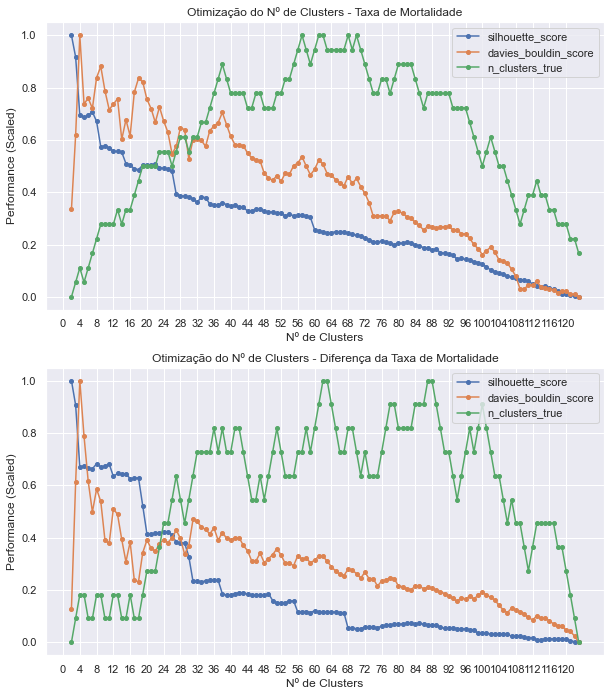

In [42]:
fig, ax = set_fig(10,18, 311); ax0 = fig.add_subplot(312)#; ax1 = fig.add_subplot(313)
cols = ['silhouette_score', 'davies_bouldin_score', 'n_clusters_true']


X_scrs[cols].plot(ax=ax, marker='o', ms=4)
ax.set(xticks=range(0, max_clusters, 4),
       title='Otimização do Nº de Clusters - Taxa de Mortalidade',
       ylabel='Performance (Scaled)',
       xlabel='Nº de Clusters')

X_dif_scrs[cols].plot(ax=ax0, marker='o', ms=4)
ax0.set(xticks=range(0, max_clusters, 4),
        title='Otimização do Nº de Clusters - Diferença da Taxa de Mortalidade',
        ylabel='Performance (Scaled)',
        xlabel='Nº de Clusters')

#agg_df_d.set_index('n_clusters').iloc[:, :-1].plot(ax=ax1, marker='o', ms=4)
#ax1.set(xticks=range(0, 133, 3), ylabel='Performance (Scaled)', xlabel='Nº de Clusters')

plt.show()

### Selecionando Parâmetros Ótimos

##### Para X baseada na métrica de silhoueta

In [43]:
opt_nums = np.array([4, 9, 15, 18, 27, 60])
colors = [tuple(np.random.choice(range(256), size=3)/255) for i in range(max(opt_nums))] + [(0,0,0)]

##### Para X_dif baseada na métrica de silhoueta

In [28]:
opt_nums_dif = np.array([4, 12, 20, 31, 56, 63, 68, 88])
colors = [tuple(np.random.choice(range(256), size=3)/255) for i in range(max(opt_nums))] + [(0,0,0)]

##### Para X_dif baseada no número real de clusters (outliers excluidos)

In [48]:
opt_nums_dif = np.array([32, 36, 42, 49, 63, 79, 88, 100, 101, 113])

### Para todo o intervalo das taxas de mortalidade

Clusters por Série ou Diferença da Série? [0 ou 1] 1


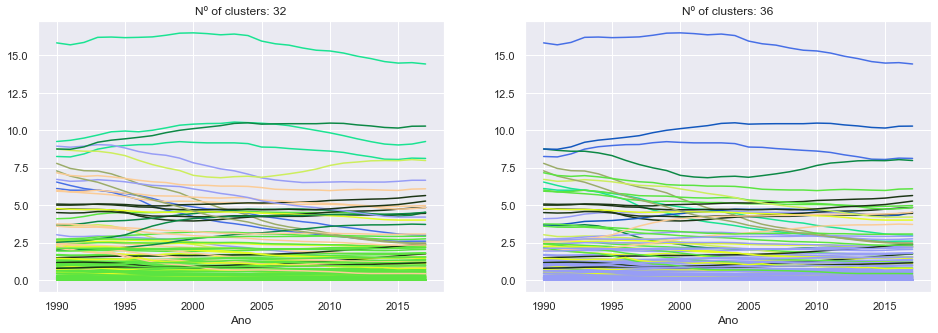

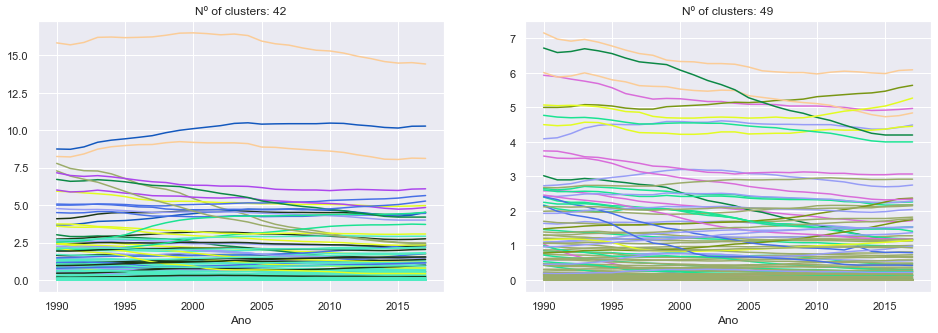

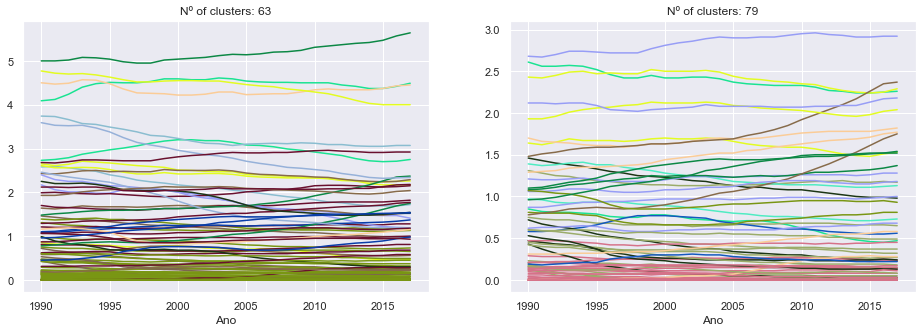

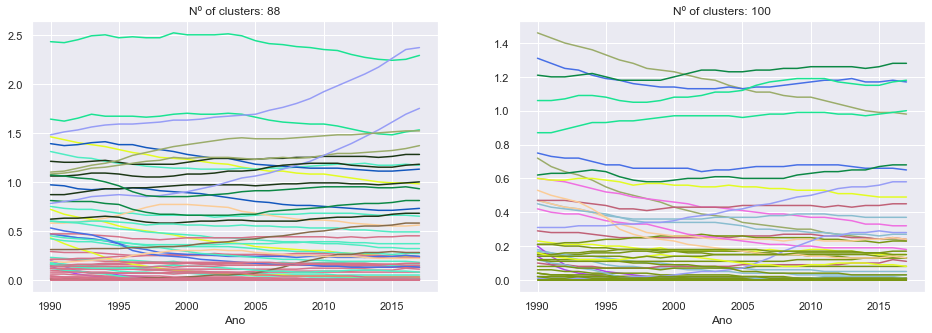

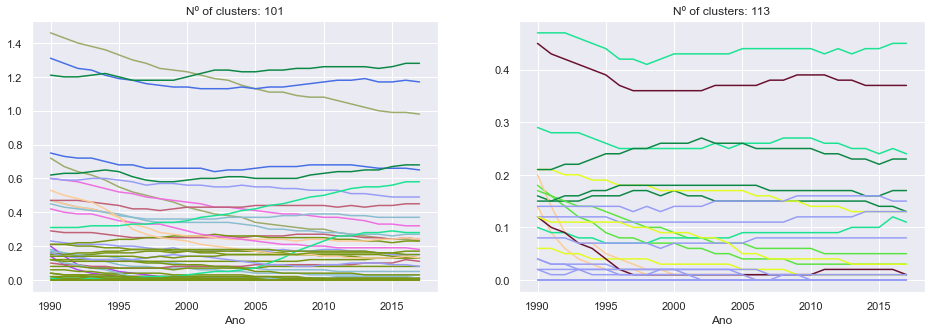

In [49]:
choice = int(input('Clusters por Série ou Diferença da Série? [0 ou 1]'))
opt = [opt_nums, opt_nums_dif][choice]
lst_6 = np.array(range(len(opt)))

for n0, n1 in zip(opt[lst_6%2==0], opt[lst_6%2!=0]):

    fig, ax0 = set_fig(16, 5, 121); ax1=fig.add_subplot(122)
    for n, ax in zip([n0, n1], [ax0, ax1]):        
        
        mask = masks[['serie', 'diff'][choice]].loc[n]
        for causa, cluster in zip(X[mask].T, [Y, Y_dif][choice].loc[n][mask]):
            X.T[causa].plot(color=colors[cluster], ax=ax)
            ax.set(title=f'Nº of clusters: {n}')
            
    plt.show()
    plt.pause(.1)

### Visualizando Clusters Individualmente

Clusters da série histórica ou da diferença da série? [0 ou 1] 1
Multiplos números de clusters? (n) [0 ou 1] 1
Usar ou não esquema de páginas? [0 ou 1] 0


Nº de Clusters: 32


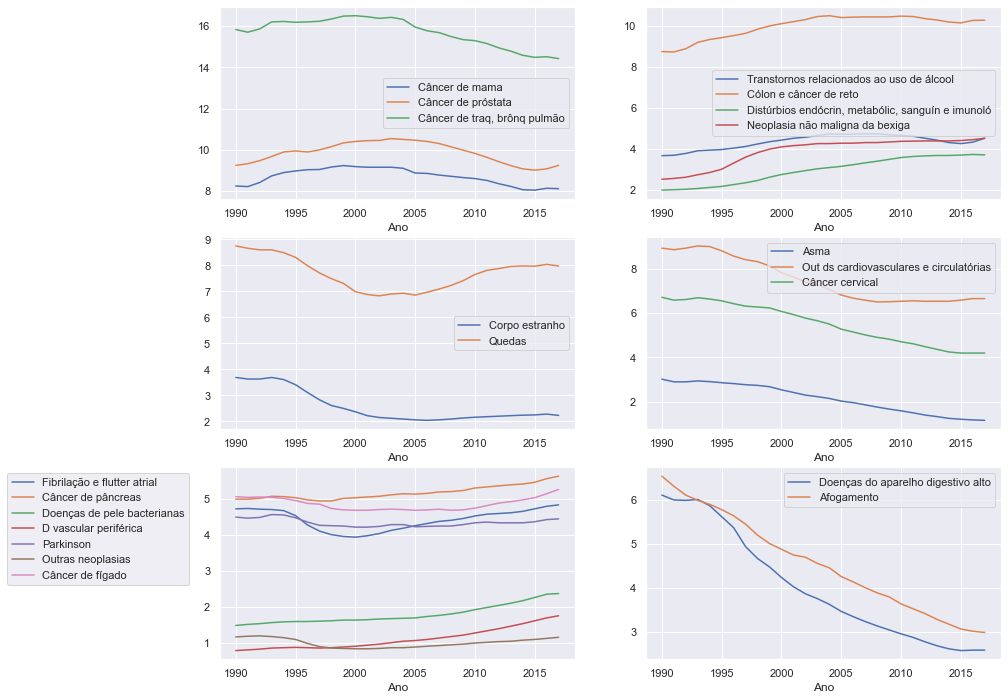

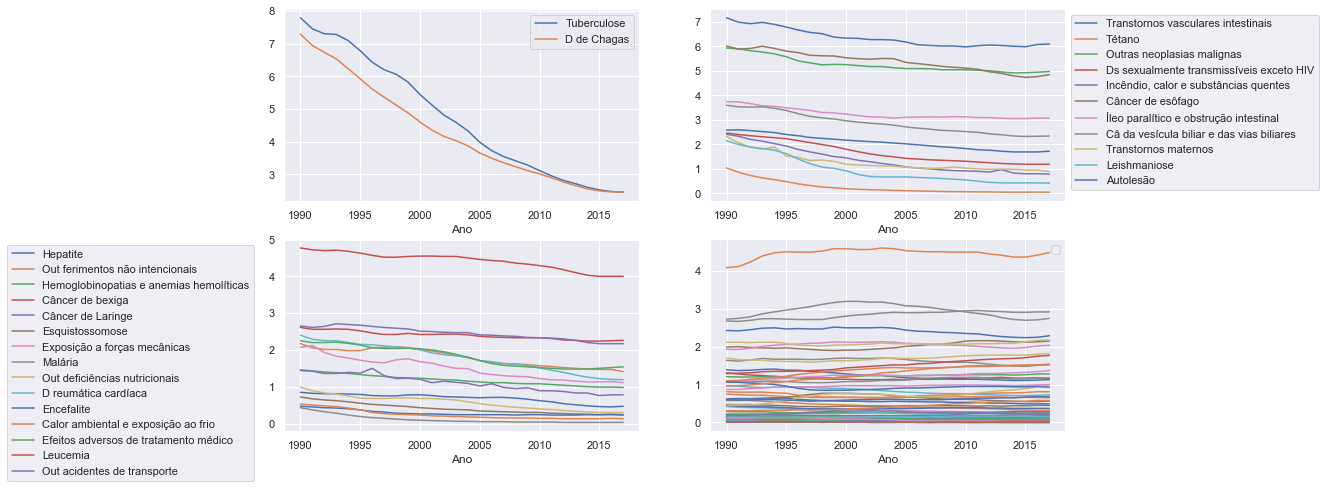

Nº de Clusters: 36


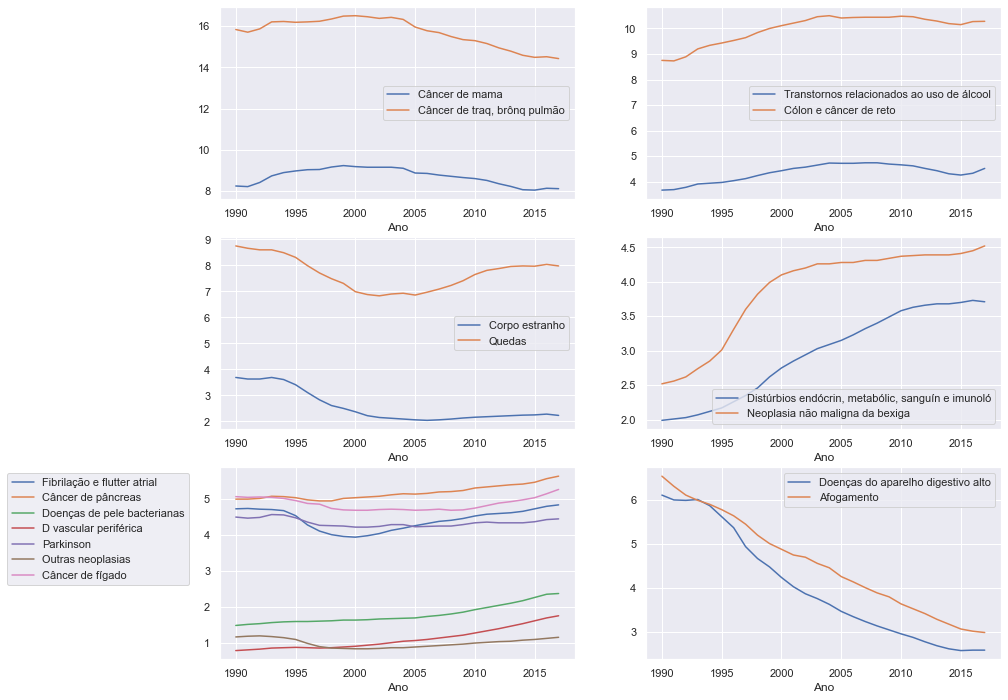

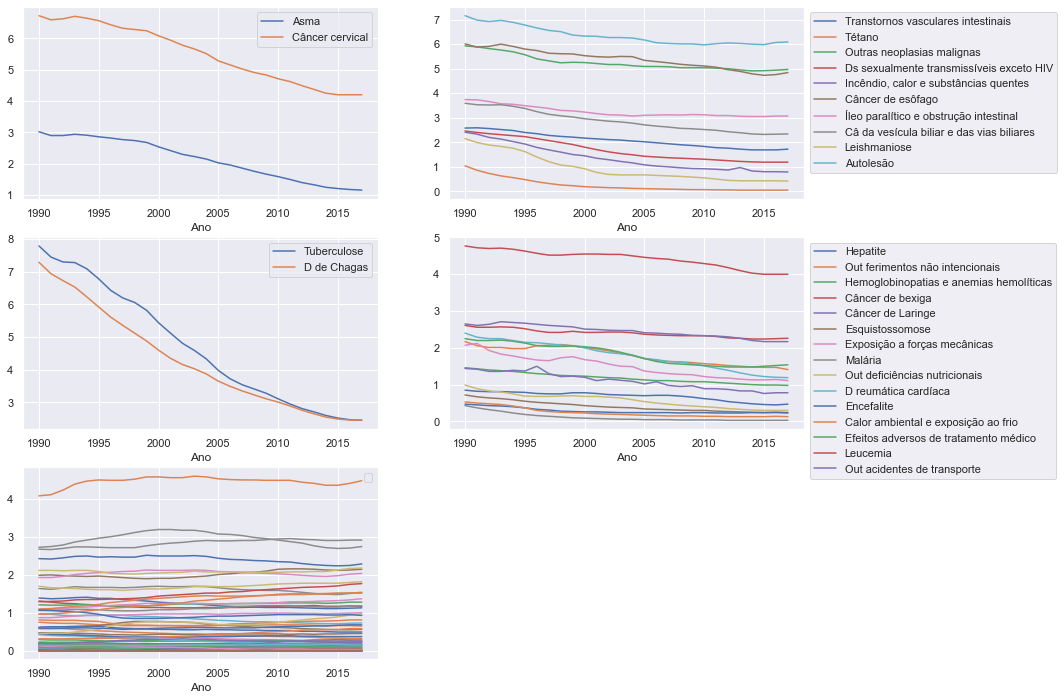

Nº de Clusters: 42


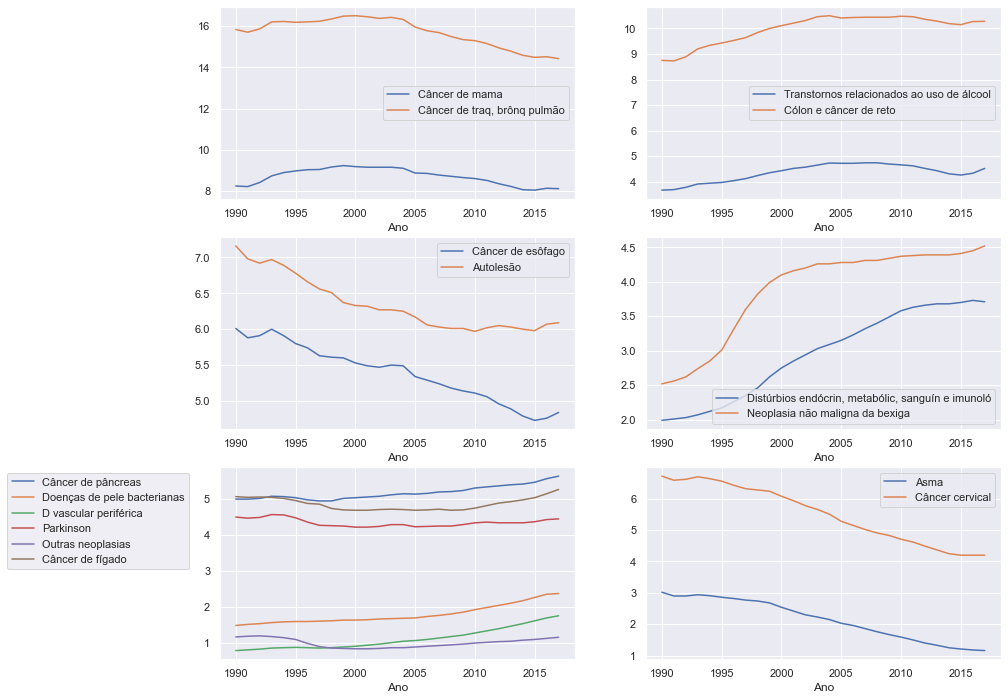

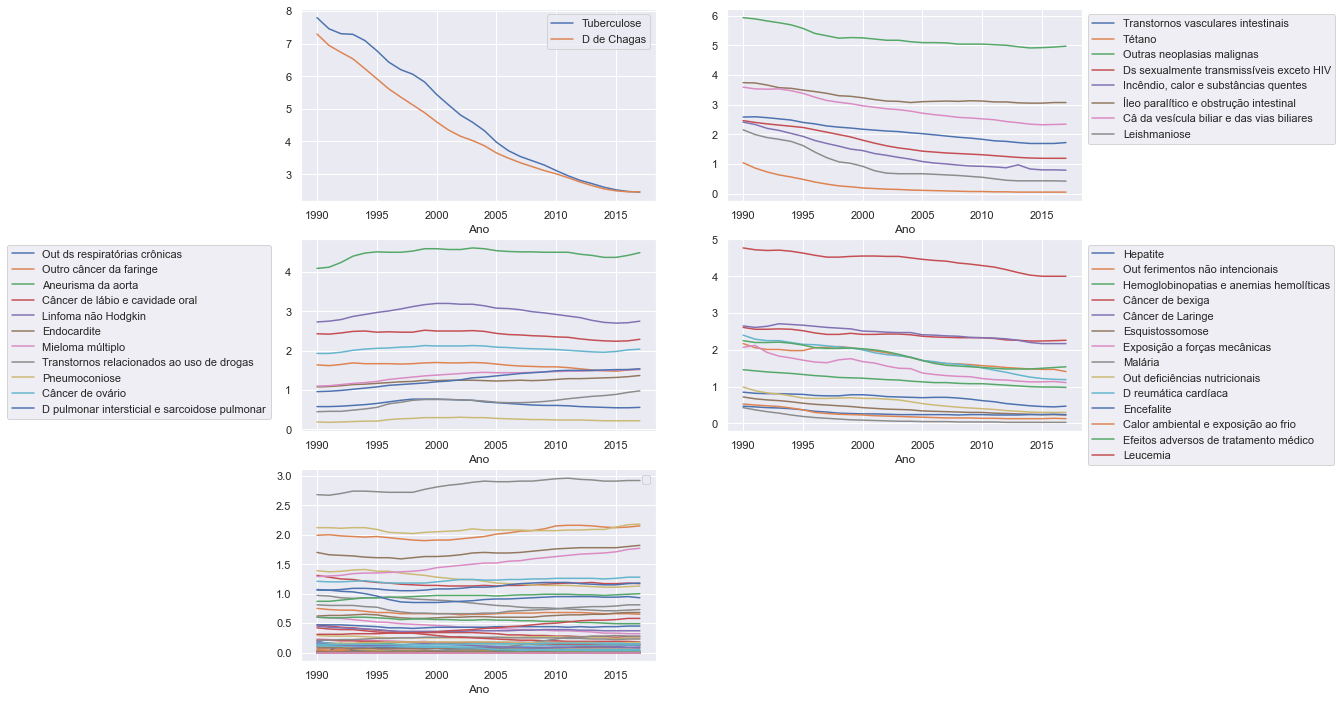

Nº de Clusters: 49


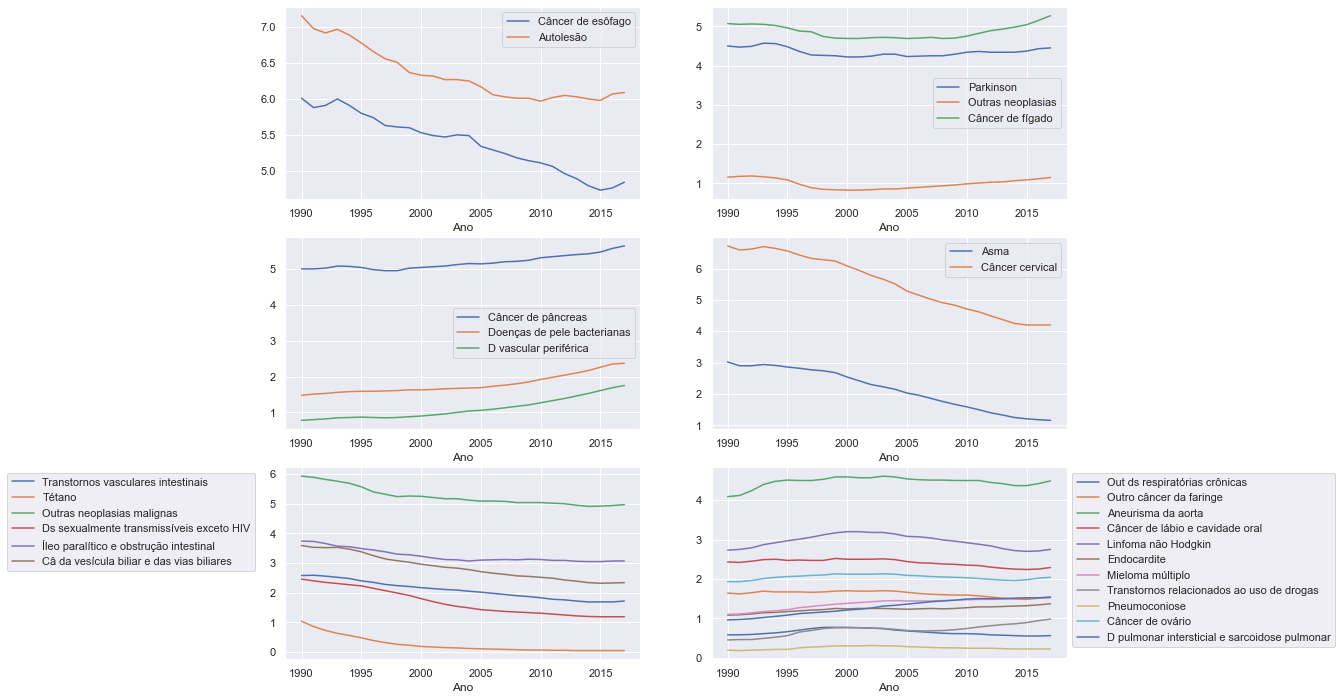

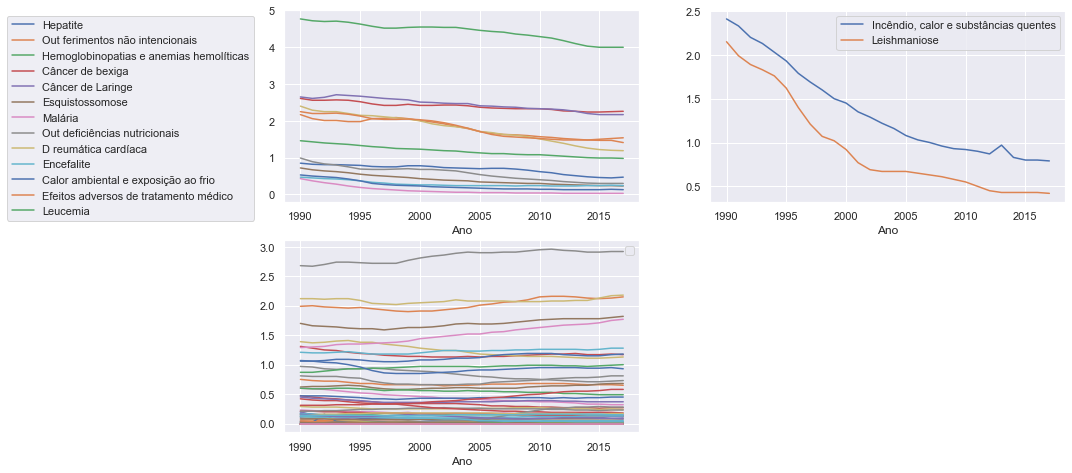

Nº de Clusters: 63


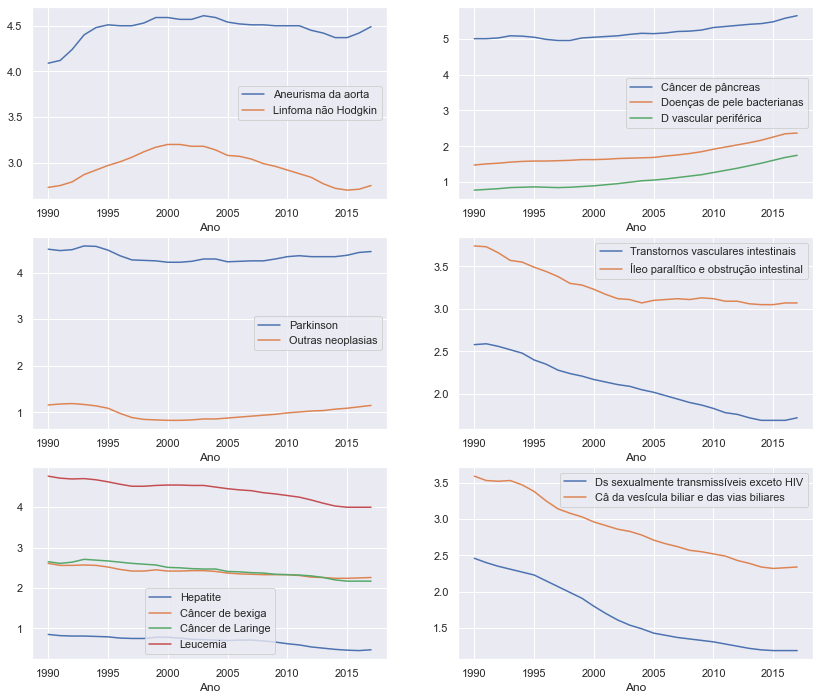

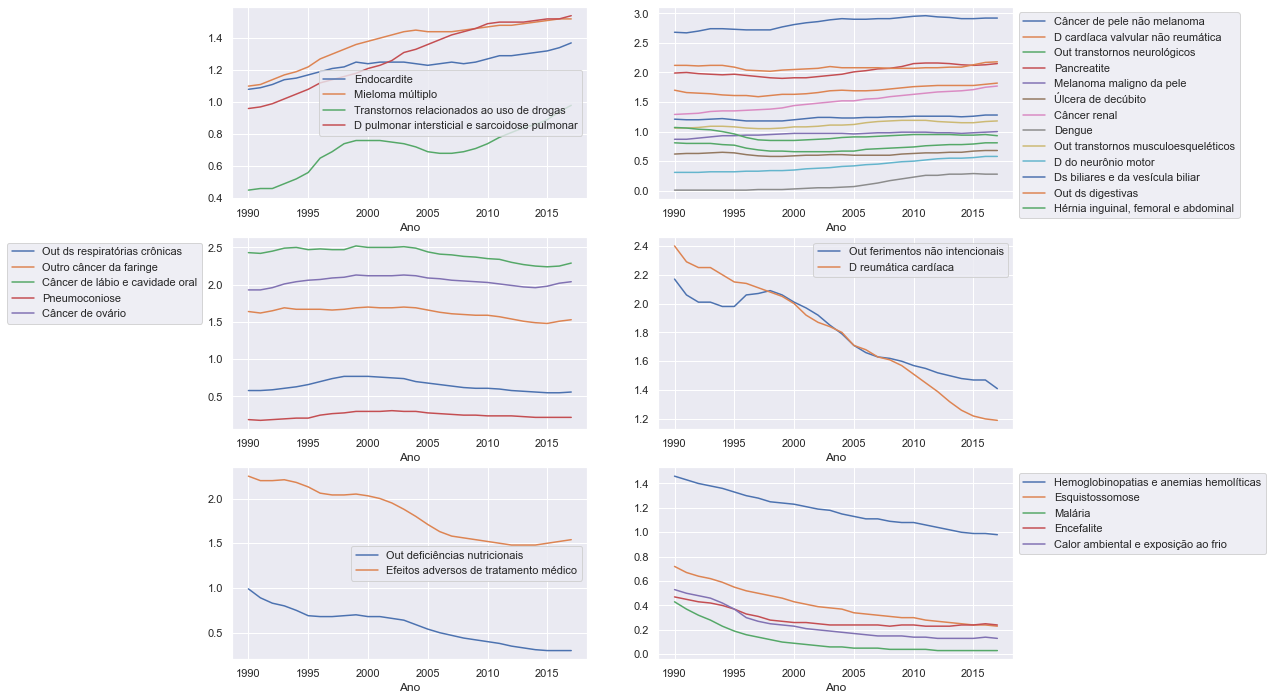

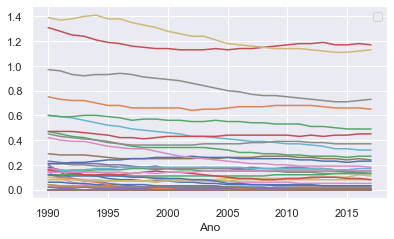

Nº de Clusters: 79


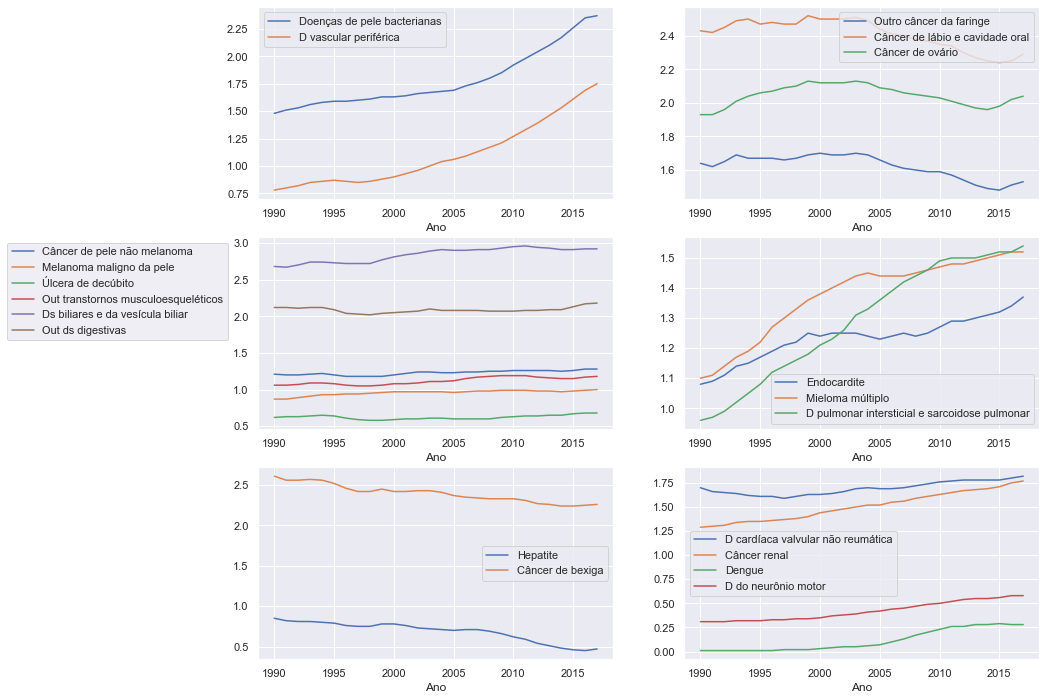

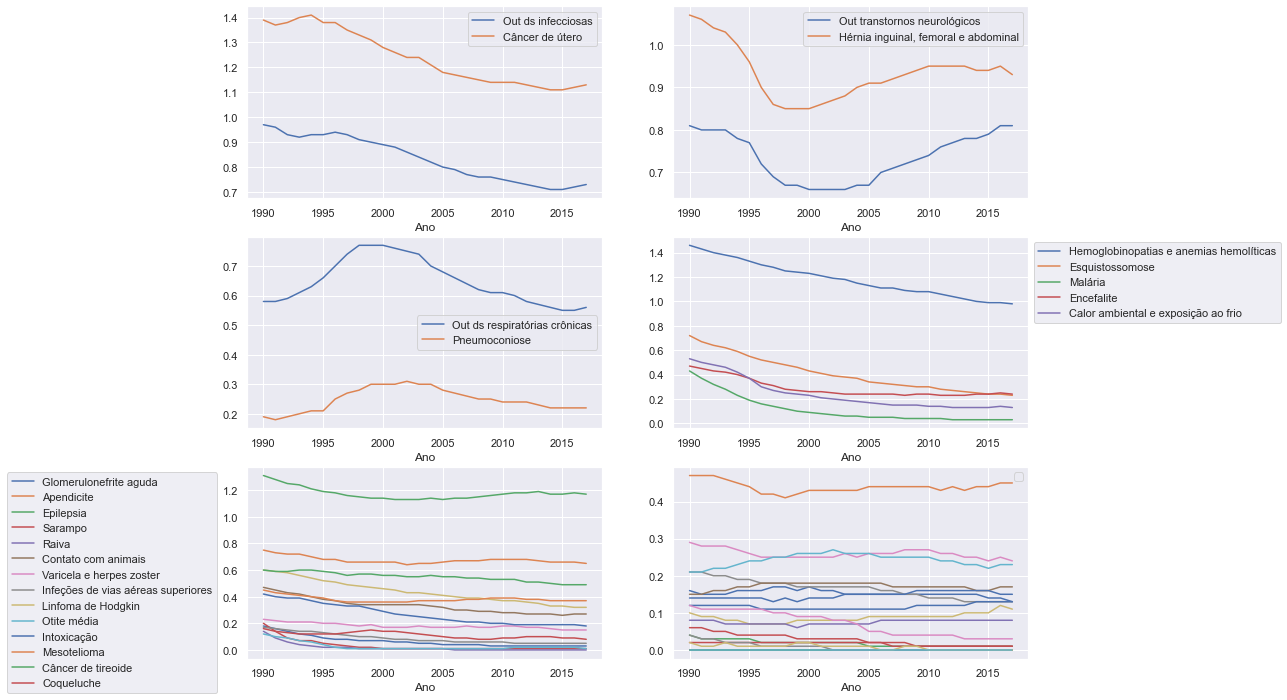

Nº de Clusters: 88


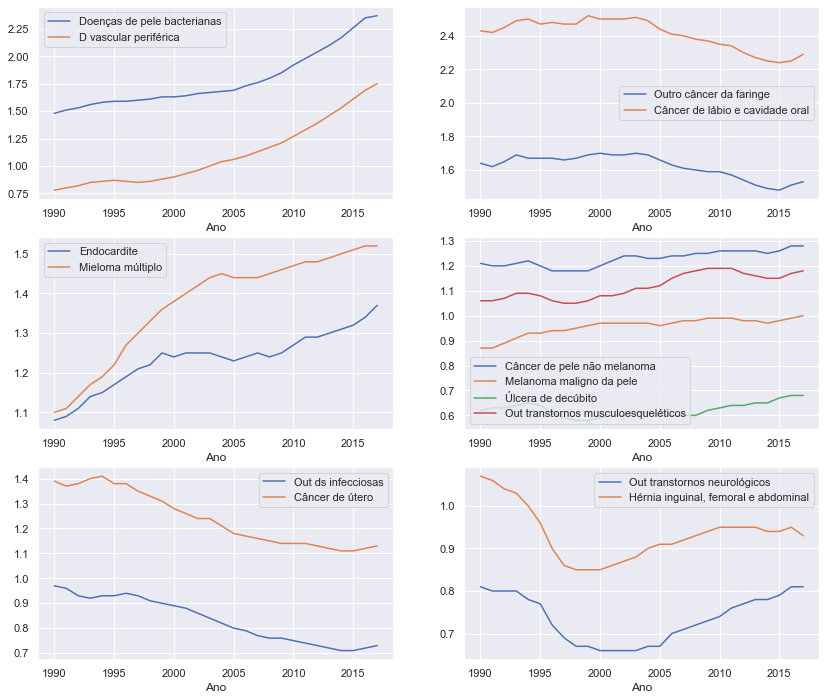

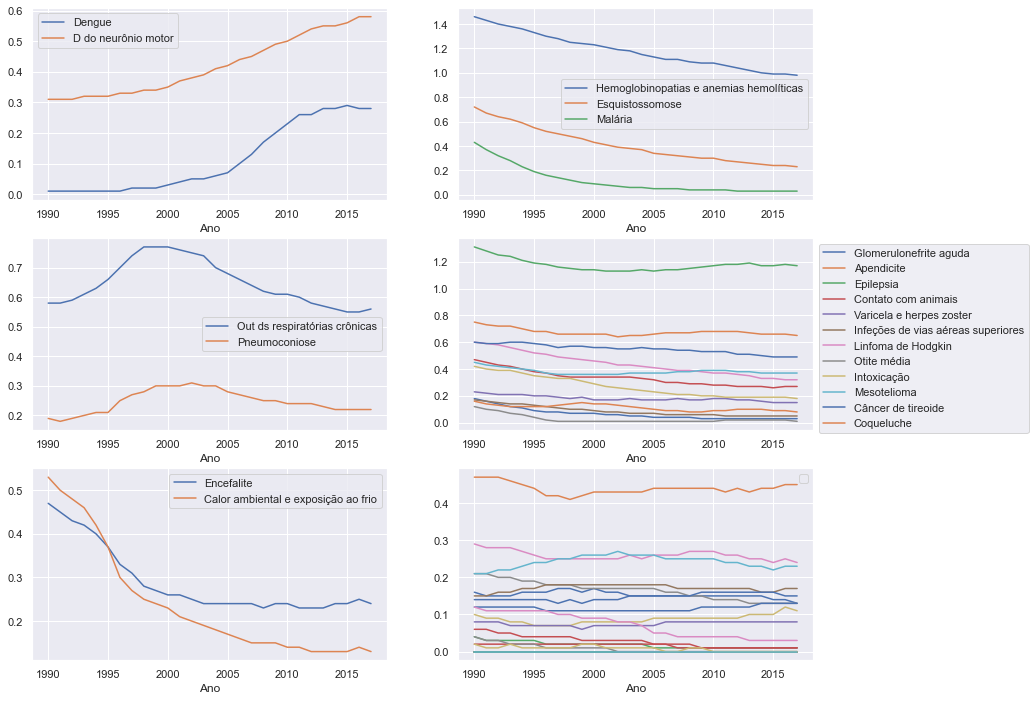

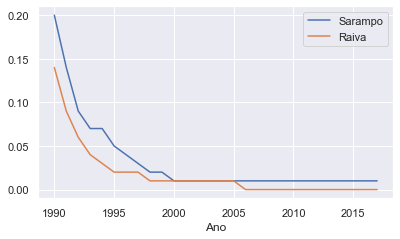

Nº de Clusters: 100


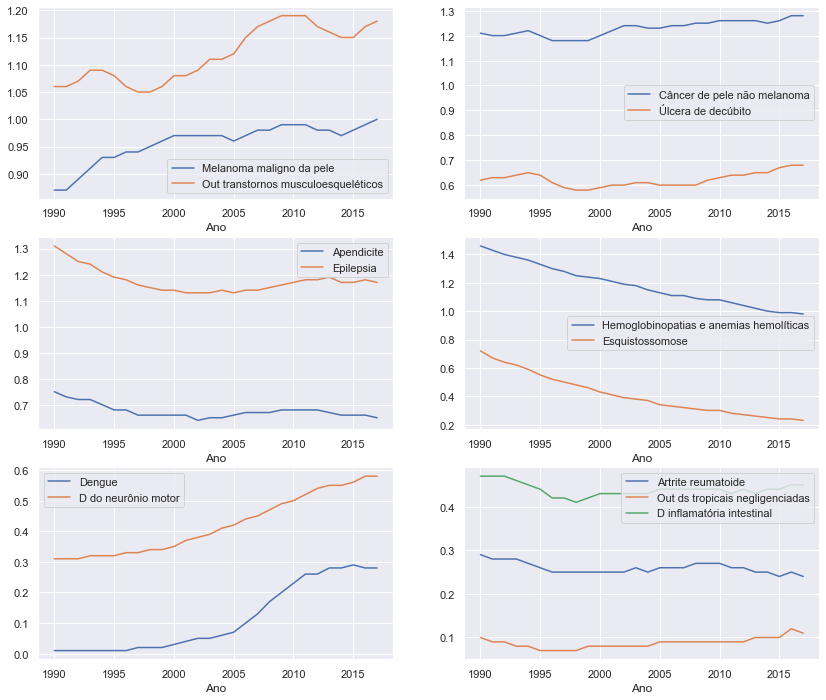

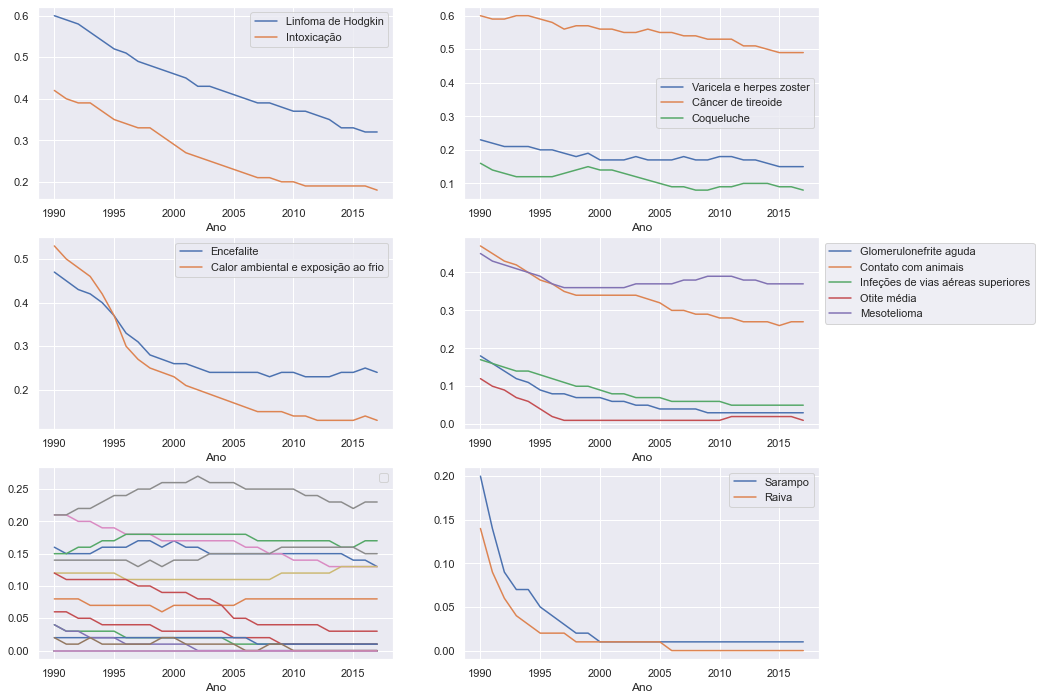

Nº de Clusters: 101


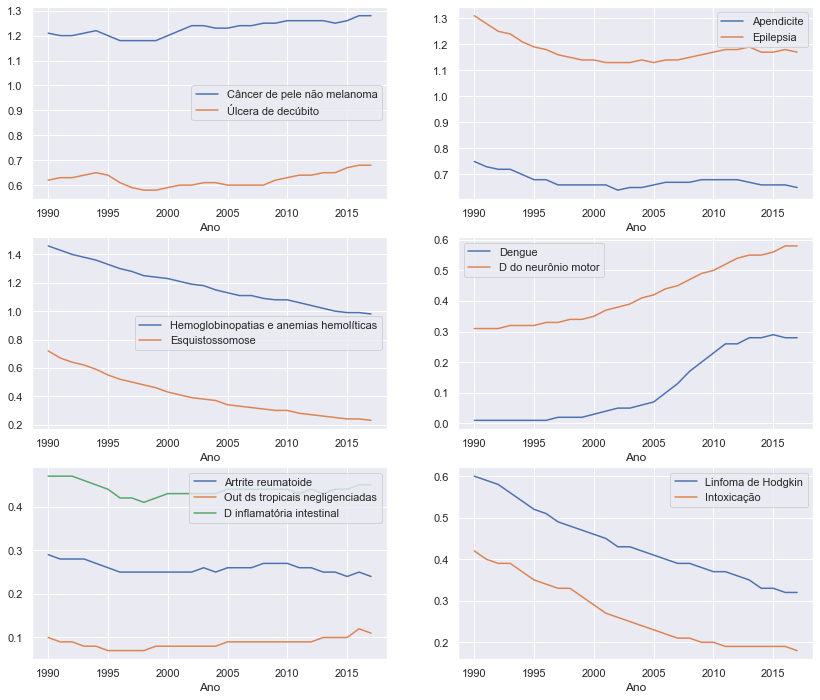

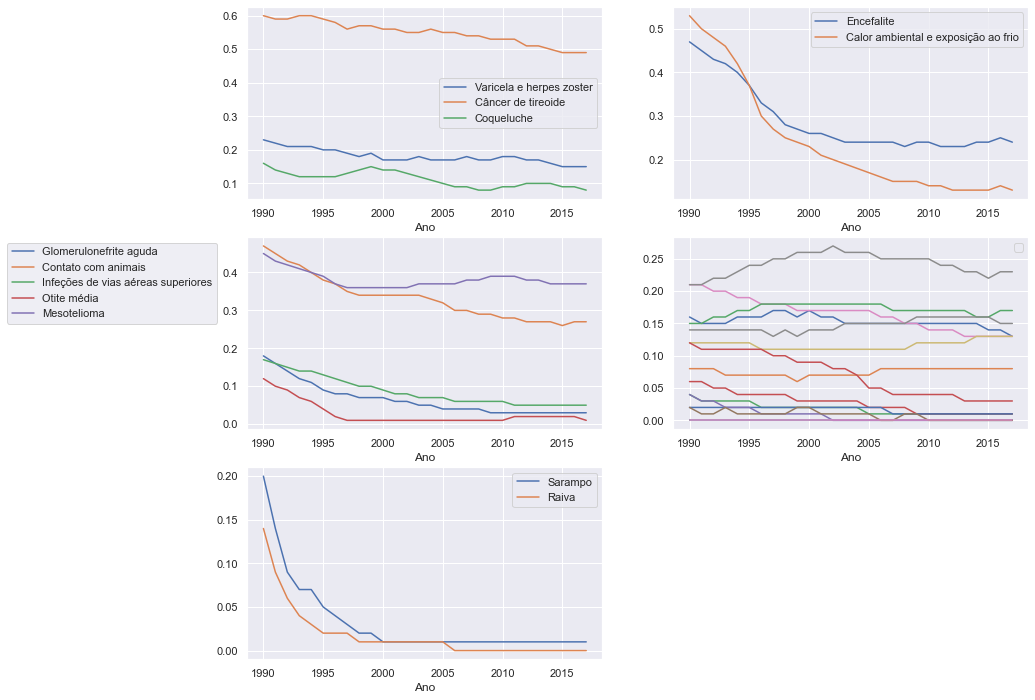

Nº de Clusters: 113


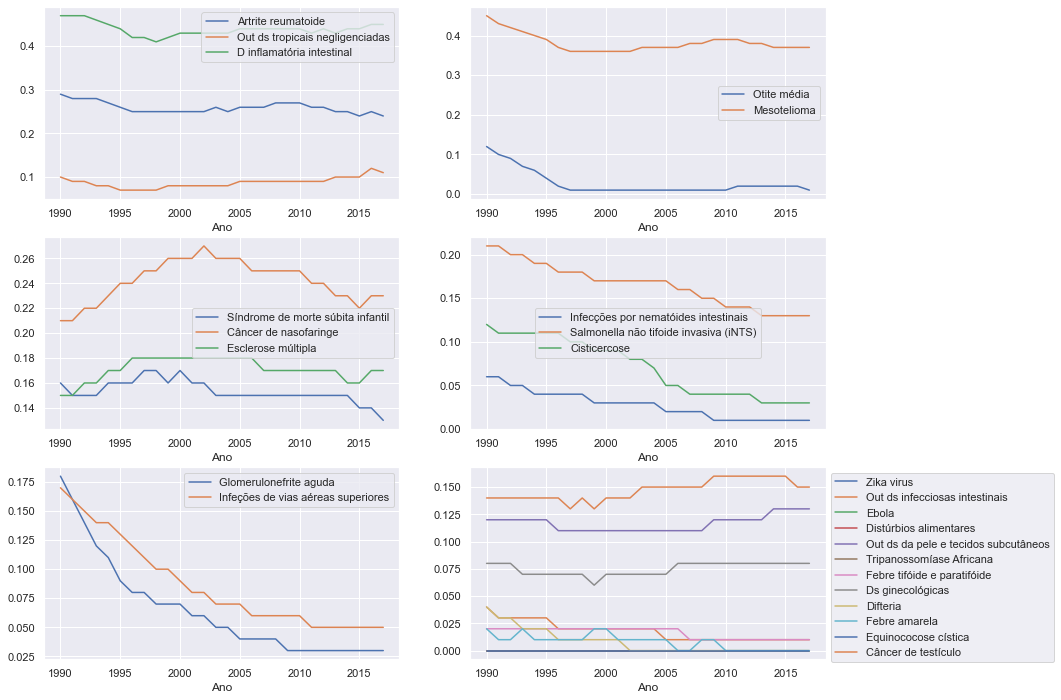

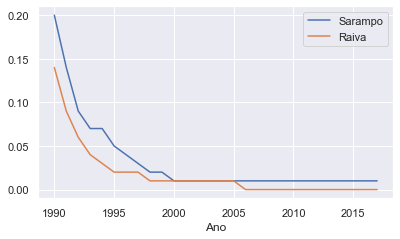

In [50]:
choice = int(input('Clusters da série histórica ou da diferença da série? [0 ou 1]'))

mult = int(input('Multiplos números de clusters? (n) [0 ou 1]'))
pages = int(input('Usar ou não esquema de páginas? [0 ou 1]'))
    
if mult:
    n_i = [opt_nums, opt_nums_dif][choice]
else:    
    n_i = [int(input('Quantos clusters? '+str([opt_nums, opt_nums_dif][choice])))]


mask_choice = ['serie', 'diff'][choice]

y = [Y, Y_dif][choice]

for n in n_i:

    labs = np.unique(y.loc[n][masks[mask_choice].loc[n]]) # Extracting Labels / for clusters with more than one death cause (through 'masks').

    sums = [X[2017][y.loc[n]==lab].mean() for lab in labs]
    labs = pd.Series(sums, index=labs).sort_values(ascending=False).index.values # Sorting labels by the mean of their mortality in 2017

    parts = list(range(0, len(labs)+6, 6))
    parts = [labs[i:j] for i,j in zip(parts, parts[1:])]

    if mult: 
        if pages:
            if input('exit?')=='y': break
            clear_output(wait=True)
        print(f'Nº de Clusters: {n}')
    for part in parts:
        
        if not mult:
            if pages:
                if input('exit?')=='y': break
                clear_output(wait=True)
            
        fig, ax = set_fig(14, 12, 321); axes = [ax] + [fig.add_subplot(3,2,i) for i in range(2,len(part)+1)]
        for i, (label, ax) in enumerate(zip(part, axes)):
            mask = y.loc[n]==label
            num_causas = sum(mask)
            X[mask].T.plot(ax=ax)#, color=[colors[label]]*num_causas)

            if num_causas>15: ax.legend([])
            elif num_causas>4: 
                if i%2!=0: ax.legend(bbox_to_anchor=(1,1))
                else: ax.legend(bbox_to_anchor=(-0.07,1))
        plt.show(); plt.pause(.1)

## Exibindo Grupos de Causas de Morte Encontrados (Por Letalidade): Resultados Finais

In [535]:
groups = {}
for n in opt_nums:

    labs = pd.Series(labels[n], index=X.index)
    
    groups[n] = {}
    for lab in labs.unique():
        groups[n][lab] = labs[labs==lab].index.tolist()

In [536]:
def report(n_clusters, method='tables', n_columns=5, filler='-'):
    
    result = groups[n_clusters]
    if method=='tables':
        
        tables = {}
        avg_mortalities = {} # Taxa de mortalidade média para cada cluster em 2017
        for key in result.keys():
            avg_mortalities[key] = X.loc[result[key]][X.columns[-1]].mean()
        sorted_keys = pd.Series(avg_mortalities).sort_values(ascending=False).index
        cnt=-1
        for key in sorted_keys:
            cnt+=1
            line_breaks = list(range(0, len(result[key])+n_columns, n_columns))        
            table = []
            for a, b in zip(line_breaks, line_breaks[1:]):    
                row = result[key][a:b]
                if len(row)<n_columns:
                    row.extend([filler]*(n_columns-len(row)))
                table.append(row)
            
            cols = [f'Cluster {cnt}'] * n_columns
            index = [f'Cluster {cnt}'] * len(table)
            tables[cnt] = pd.DataFrame(table, columns=cols, index=index)
            #tables[key].index.name = 'Causas de morte'
    
    return tables

## Resultados para 4 Grupos

In [537]:
n_i = []
for n in opt_nums: n_i.append(report(n_clusters=n, n_columns=4))

In [547]:
a = int(input('Index do valor ótimo:')); ylim=int(input('Limite superior de y:'))

Index do valor ótimo: 5
Limite superior de y: 5


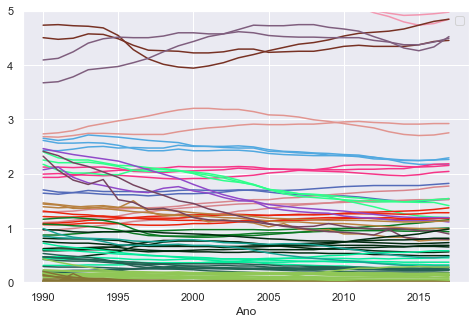

Cluster 26         Cluster 26 Cluster 26  \
Cluster 26  Outras neoplasias malignas  Câncer de esôfago          -   

           Cluster 26  
Cluster 26          -

Cluster 27 Cluster 27 Cluster 27 Cluster 27
Cluster 27  Fibrilação e flutter atrial  Parkinson          -          -

Cluster 29                                 Cluster 29  \
Cluster 29  Aneurisma da aorta  Transtornos relacionados ao uso de álcool   

           Cluster 29 Cluster 29  
Cluster 29          -          -

Cluster 37                        Cluster 37 Cluster 37  \
Cluster 37  Linfoma não Hodgkin  Ds biliares e da vesícula biliar          -   

           Cluster 37  
Cluster 37          -

Cluster 43         Cluster 43  \
Cluster 43  Câncer de bexiga  Câncer de Laringe   

                                 Cluster 43 Cluster 43  
Cluster 43  Câncer de lábio e cavidade oral          -

Cluster 45        Cluster 45         Cluster 45 Cluster 45
Cluster 45  Pancreatite  Câncer de ovário  Out ds digestivas          -

Cluster 48                         Cluster 48  \
Cluster 48  Outro câncer da faringe  D cardíaca valvular não reumática   

           Cluster 48 Cluster 48  
Cluster 48          -          -

Cluster 49    Cluster 49  \
Cluster 49  Mieloma múltiplo  Câncer renal   

                                               Cluster 49 Cluster 49  
Cluster 49  D pulmonar intersticial e sarcoidose pulmonar          -

Cluster 50            Cluster 50  \
Cluster 50  Out ferimentos não intencionais  D reumática cardíaca   

                                       Cluster 50 Cluster 50  
Cluster 50  Efeitos adversos de tratamento médico          -

Cluster 52                   Cluster 52   Cluster 52  \
Cluster 52  Epilepsia  Câncer de pele não melanoma  Endocardite   

                                     Cluster 52  
Cluster 52  Out transtornos musculoesqueléticos

Cluster 54  \
Cluster 54  Exposição a forças mecânicas   

                                          Cluster 54 Cluster 54 Cluster 54  
Cluster 54  Ds sexualmente transmissíveis exceto HIV          -          -

Cluster 55         Cluster 55  \
Cluster 55  Melanoma maligno da pele  Outras neoplasias   

                                      Cluster 55 Cluster 55  
Cluster 55  Hérnia inguinal, femoral e abdominal          -

Cluster 56       Cluster 56  \
Cluster 56  Hemoglobinopatias e anemias hemolíticas  Câncer de útero   

                             Cluster 56 Cluster 56  
Cluster 56  Out acidentes de transporte          -

Cluster 57            Cluster 57  \
Cluster 57  Incêndio, calor e substâncias quentes  Transtornos maternos   

           Cluster 57 Cluster 57  
Cluster 57          -          -

Cluster 58                                 Cluster 58  \
Cluster 58          Apendicite              Out ds respiratórias crônicas   
Cluster 58  Úlcera de decúbito  Transtornos relacionados ao uso de drogas   

                    Cluster 58                    Cluster 58  
Cluster 58  Out ds infecciosas  Out transtornos neurológicos  
Cluster 58  Câncer de tireoide                             -

Cluster 60          Cluster 60  \
Cluster 60      Esquistossomose  Linfoma de Hodgkin   
Cluster 60  D do neurônio motor                   -   

                           Cluster 60   Cluster 60  
Cluster 60  D inflamatória intestinal  Mesotelioma  
Cluster 60                          -            -

Cluster 61                     Cluster 61 Cluster 61 Cluster 61
Cluster 61   Hepatite  Out deficiências nutricionais          -          -

Cluster 63                           Cluster 63  \
Cluster 63  Contato com animais                   Artrite reumatoide   
Cluster 63          Intoxicação  Calor ambiental e exposição ao frio   

                       Cluster 63  Cluster 63  
Cluster 63  Câncer de nasofaringe  Encefalite  
Cluster 63          Pneumoconiose           -

Cluster 64                              Cluster 64  \
Cluster 64  Glomerulonefrite aguda       Síndrome de morte súbita infantil   
Cluster 64                 Malária  Salmonella não tifoide invasiva (iNTS)   
Cluster 64        Ds ginecológicas                                  Dengue   
Cluster 64              Coqueluche                     Câncer de testículo   

                                 Cluster 64  \
Cluster 64         Varicela e herpes zoster   
Cluster 64  Out ds tropicais negligenciadas   
Cluster 64               Esclerose múltipla   
Cluster 64                                -   

                                      Cluster 64  
Cluster 64    Infeções de vias aéreas superiores  
Cluster 64  Out ds da pele e tecidos subcutâneos  
Cluster 64                          Cisticercose  
Cluster 64                                     -

Cluster 67                Cluster 67  \
Cluster 67                               Sarampo                Zika virus   
Cluster 67  Infecções por nematóides intestinais                     Ebola   
Cluster 67                           Otite média  Tripanossomíase Africana   
Cluster 67                         Febre amarela      Equinococose cística   

                             Cluster 67                      Cluster 67  
Cluster 67                        Raiva  Out ds infecciosas intestinais  
Cluster 67       Distúrbios alimentares          Conflict and terrorism  
Cluster 67  Febre tifóide e paratifóide                        Difteria  
Cluster 67                            -                               -

In [548]:
fig, ax = set_fig(8,5)
for cluster in n_i[a].keys():
    
    causas = np.unique(n_i[a][cluster])
    if sum(causas!='-')>1:
        for causa in causas:    
            if causa!='-':            
                X.loc[causa].plot(color=colors[cluster], ax=ax)

ax.set(ylim=(0, ylim))
ax.legend([])
plt.show()

for key in n_i[a].keys():
    
    if sum( np.unique(n_i[a][key])!='-' ) > 1:
        display(n_i[a][key])

### Série Histórica Excluindo Causas de Morte sem grupos

---

# Engenharia de Features

#### Novas variáveis: 
* Diferença Anual da taxa de mortalidade

In [317]:
X_dif = pd.DataFrame(np.diff(X),
                     columns = [str(i)+'-'+str(j) for i,j in zip(X.columns, X.columns[1:])],
                     index = X.index
)

In [317]:
X_eng = pd.concat([X, X_dif], 1)

In [320]:
X_eng[:5]

1990   1991   1992   1993   1994   1995   1996  \
Glomerulonefrite aguda        0.18   0.16   0.14   0.12   0.11   0.09   0.08   
Câncer de mama                8.25   8.22   8.42   8.74   8.90   8.98   9.04   
Hepatite                      0.85   0.82   0.81   0.81   0.80   0.79   0.76   
Apendicite                    0.75   0.73   0.72   0.72   0.70   0.68   0.68   
Cardiomiopatia e miocardite  10.90  11.23  11.66  12.20  12.58  12.76  13.04   

                              1997   1998   1999  ...  2007-2008  2008-2009  \
Glomerulonefrite aguda        0.08   0.07   0.07  ...       0.00      -0.01   
Câncer de mama                9.05   9.17   9.24  ...      -0.06      -0.06   
Hepatite                      0.75   0.75   0.78  ...      -0.02      -0.03   
Apendicite                    0.66   0.66   0.66  ...       0.00       0.01   
Cardiomiopatia e miocardite  13.06  13.11  13.07  ...      -0.34      -0.26   

                             2009-2010  2010-2011  2011-2012  2012-2013  \
Glomerulonefrite aguda            0.00       0.00       0.00       0.00   
Câncer de mama                   -0.05      -0.09      -0.16      -0.13   
Hepatite                         -0.04      -0.03      -0.05      -0.03   
Apendicite                        0.00       0.00       0.00      -0.01   
Cardiomiopatia e miocardite      -0.23      -0.23      -0.23      -0.13   

                             2013-2014  2014-2015  2015-2016  2016-2017  
Glomerulonefrite aguda            0.00       0.00       0.00       0.00  
Câncer de mama                   -0.16      -0.02       0.09      -0.02  
Hepatite                         -0.03      -0.02      -0.01       0.02  
Apendicite                       -0.01       0.00       0.00      -0.01  
Cardiomiopatia e miocardite      -0.12      -0.07       0.09       0.28  

[5 rows x 55 columns]

### Optimização de parâmentros para 'Cluster Aglomerativo'

#### Otimizando Nº de Clusters

In [462]:
agg_scrs, max_clusters = [], 80
n_clusters = range(2, max_clusters)
Y_n = []
for n in n_clusters:    
    clear_output(wait=True); print(f'{n}/{max_clusters}')
   
    model = AgglomerativeClustering(n_clusters=n, distance_threshold=None).fit(X_dif)
    labels = model.labels_; Y_n.append(labels)
    
    # Substituindo rótulos "-1" por "0"
    num_labels = len(np.unique(labels))
    if num_labels==len(X): 
        labels[labels==0] = 1
        
    agg_scrs.append([metric(X_dif, labels) for metric in metrics])

Y_n = pd.DataFrame(Y_n, columns=X.index, index=n_clusters)
agg_df_n = pd.DataFrame(mms().fit_transform(agg_scrs), columns=metrics_names, index=n_clusters)

79/80


### Visualizando performance para diferentes nº de clusters

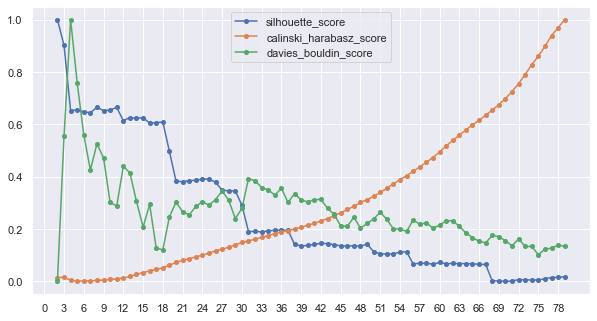

In [464]:
fig, ax = set_fig(10,18, 311)
agg_df_n.plot(ax=ax, marker='o', ms=4)
ax.set(xticks=range(0, max_clusters, 3))

plt.show()

### Visualizando Agrupamentos para Parâmetros Selecionados

In [324]:
opt_nums = np.array([4, 9, 18, 27, 60, 79])
colors = [tuple(np.random.choice(range(256), size=3)/255) for i in range(max(opt_nums))] + [(0,0,0)]

In [465]:
opt_nums = np.array([4, 20, 31, 38, 56, 68])
colors = [tuple(np.random.choice(range(256), size=4)/255) for i in range(max(opt_nums))] + [(0,0,0)]

#### Para todo o intervalo das taxas de mortalidade

In [466]:
masks = []
for n in Y_n.index:
    row = Y_n.loc[n]
    new_row = []
    for label in row: new_row.append((row==label).sum()!=1)
    masks.append(new_row)
masks = pd.DataFrame(masks, index=Y_n.index, columns=Y_n.columns)

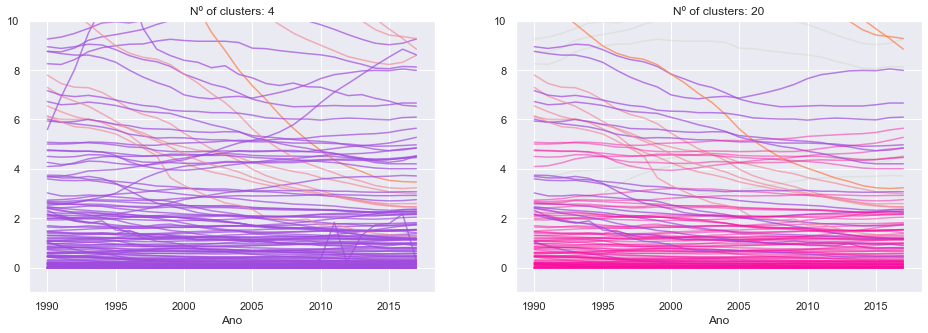

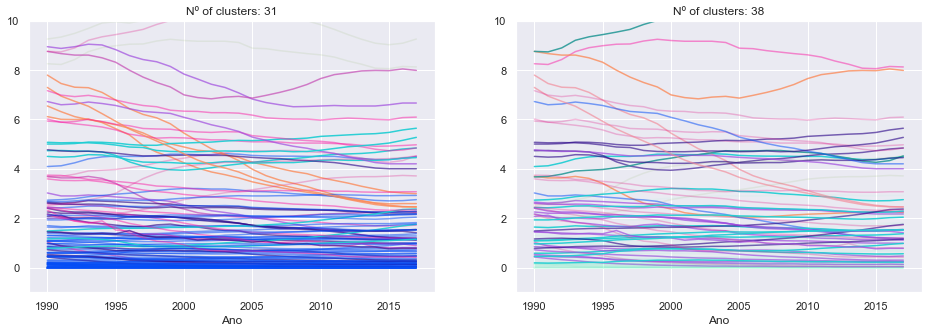

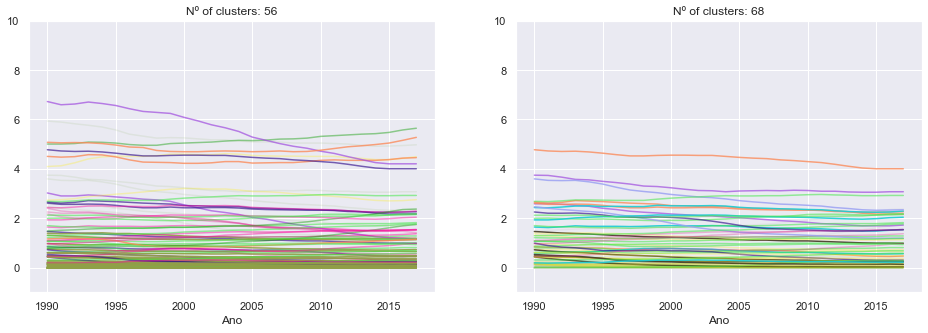

In [468]:
lst_6 = np.array(range(len(opt_nums)))

for n0, n1 in zip(opt_nums[lst_6%2==0], opt_nums[lst_6%2!=0]):

    fig, ax0 = set_fig(16, 5, 121); ax1=fig.add_subplot(122)
    for n, ax in zip([n0, n1], [ax0, ax1]):        
        for causa, cluster in zip(X.index[masks.loc[n]], Y_n.loc[n][masks.loc[n]]):
            X.loc[causa].plot(color=colors[cluster], ax=ax)
            ax.set(ylim=(-1, 10), title=f'Nº of clusters: {n}')
    
    plt.show()
    plt.pause(.1)

In [469]:
colors = [list(np.random.choice(range(256), size=3)/255) for i in range(max(opt_nums))] + [(0,0,0)]

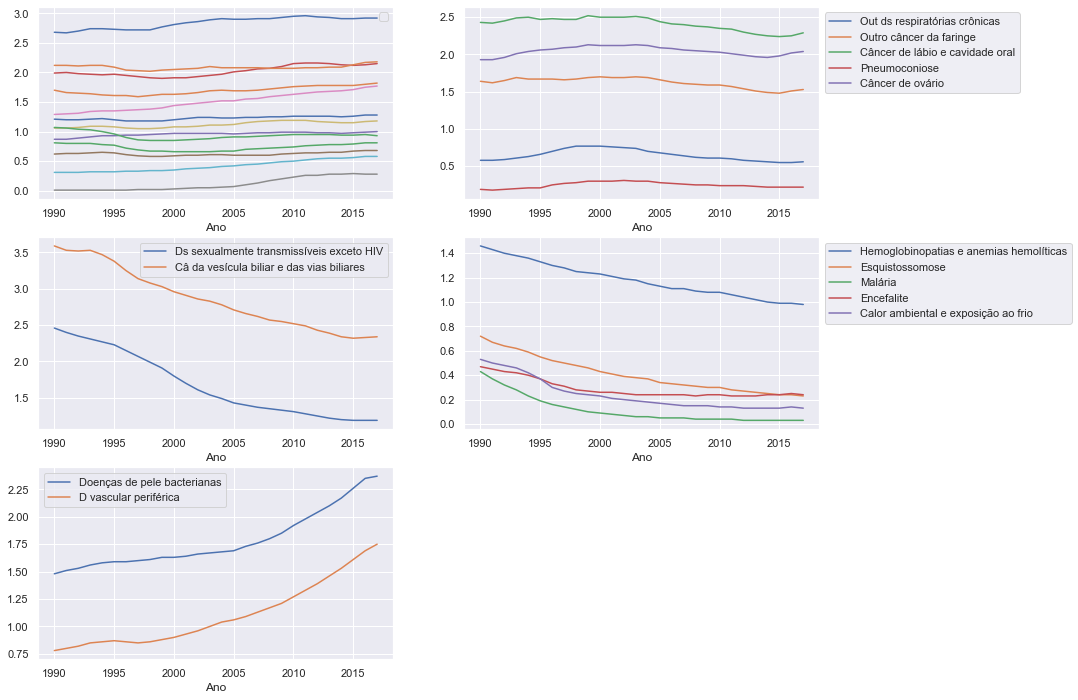

In [526]:
n=opt_nums[int(input(str(opt_nums)))]

labs = np.unique(Y_n.loc[n][masks.loc[n]])
parts = list(range(0, len(labs)+6, 6))
parts = [labs[i:j] for i,j in zip(parts, parts[1:])]
for part in parts:
    if input('exit?')=='y': break

    fig, ax = set_fig(14, 12, 321); axes = [ax] + [fig.add_subplot(3,2,i) for i in range(2,len(part)+1)]
    for i, (label, ax) in enumerate(zip(part, axes)):
        num_causas = sum(Y_n.loc[n]==label)
        X[Y_n.loc[n]==label].T.plot(ax=ax)#, color=[colors[label]]*num_causas)
        
        if num_causas>10: ax.legend([])
        elif num_causas>4: 
            if i%2!=0: ax.legend(bbox_to_anchor=(1,1))
            else: ax.legend(bbox_to_anchor=(-0.05,1))
    clear_output(wait=True)
    plt.show(); plt.pause(.1)
